# 3-period-lived Agents with Exogenous Labor Supply

## Exercise 2.1

In [1]:
import numpy as np

In [2]:
# calibration
beta = 0.442
delta = 0.6415
sigma = 3
A = 1
alpha = 0.35
nvec = (1.0, 1.0, .2)
f_params = (nvec, A, alpha, delta)

In [3]:
# firm FOC for capital
def get_r(K, params):
    nvec, A, alpha, delta = params
    r = alpha*A*(sum(nvec)/K)**(1-alpha) - delta
    return r
    

# firm FOC for labor
def get_w(K, params):
    nvec, A, alpha, delta = params
    w = (1-alpha)*A*(K/sum(nvec))**alpha 
    return w

In [4]:
def feasible(f_params, bvec_guess):
    '''
    This function checks the feasibility of a guess given parameters.
    
    Inputs:
        f_params: a tuple of parameters (nvec, A, alpha, delta)
        bvec_guess: a guess for the steady-state savings vector
        
    Outputs:
        b_cnstr (Boolean vector of length 2):
            denotes which element of bvec guess is likely responsible for any of the
            consumption nonnegativity constraint violations identified in c cnstr
        c_cnstr (Boolean vector of length 3):
            the s-th element True if c_s <= 0 given f_params and bvec_guess 
        K_cnstr (Boolean vector of length 1):
            True if K <= 0 given f_params and bvec_guess
    '''
    # unpack inputs
    nvec, A, alpha, delta = f_params
    b2,b3 = bvec_guess
    
    K = b2 + b3
    
    # capital feasibility constraint
    K_cnstr = np.array([K <= 0])
    
    # consumption feasibility constraint
    c1 = get_w(K,f_params)*nvec[0] - b2
    c2 = get_w(K,f_params)*nvec[1] + (1+get_r(K,f_params))*b2 - b3
    c3 = get_w(K,f_params)*nvec[2] + (1+get_r(K,f_params))*b3 
    c_cnstr = np.array([c1 <= 0, c2 <= 0, c3 <=0])
    
    # responsible b guess
    b_cnstr = np.full(2, False)
    if c_cnstr[0] == True:
        b_cnstr[0] = True
    if c_cnstr[1] == True:
        b_cnstr[0] = True
        b_cnstr[1] = True
    if c_cnstr[2] == True:
        b_cnstr[1] = True

    return b_cnstr, c_cnstr, K_cnstr

In [5]:
feasible(f_params, np.array([1.0, 1.2]))

(array([ True, False]), array([ True, False, False]), array([False]))

In [6]:
feasible(f_params, np.array([0.06, -0.001]))

(array([False, False]), array([False, False, False]), array([False]))

In [7]:
feasible(f_params, np.array([0.1, 0.1]))

(array([False, False]), array([False, False, False]), array([False]))

## Exercise 2.2

In [8]:
import time
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [9]:
def EulErr(bvec, params):
    
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
    b2, b3 = bvec
    K = b2 + b3
    f_params = (nvec, A, alpha, delta)
    
    # wage and rental rate
    w = get_w(K,f_params)
    r = get_r(K,f_params)
    
    # consumption
    c1 = w * nvec[0] - b2
    c2 = w * nvec[1] + (1 + r) * b2 - b3
    c3 = w * nvec[2] + (1 + r) * b3
    
    # Euler errors
    EulErr1 = beta * (1 + r) * c2 ** (-sigma) - c1 ** (-sigma) 
    EulErr2 = beta * (1 + r) * c3 ** (-sigma) - c2 ** (-sigma) 
    
    return EulErr1, EulErr2

In [10]:
def get_SS(params, bvec_guess, SS_graphs):
    '''
    compute the steady-state equilibrium 
    
    Inputs:
    params: a tuple of the parameters for the model params 
        = (beta, sigma, nvec, L, A, alpha, delta, SS_tol)
    bvec_guess: an initial guess of the steady-state savings
    SS_graphs: a Boolean that generates a figure of the steady-state distribution
    
    Outputs: 
    a Python dictionary with the steady-state solution values
    '''
    # unpack parameters
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
    f_params = (nvec, A, alpha, delta)
    
    start_time = time.perf_counter() # Place at beginning of get_SS()
    
    # solve Euler equations
    ss = opt.root(EulErr, bvec_guess, tol = SS_tol, args = params) 
    b_ss = ss.x
    K_ss = sum(b_ss)
    w_ss = get_w(K_ss, f_params)
    r_ss = get_r(K_ss, f_params)
    c_ss = (w_ss * nvec[0] - b_ss[0],
            w_ss * nvec[1] + (1 + r_ss) * b_ss[0] - b_ss[1],
            w_ss * nvec[2] + (1 + r_ss) * b_ss[1])
    Y_ss = A * K_ss**alpha * L**(1-alpha)
    C_ss = sum(c_ss)
    
    ss_time = time.perf_counter() - start_time # Place at end of get_SS()
    
    EulErr_ss = EulErr(b_ss, params)
    RCerr_ss = Y_ss - C_ss - delta * K_ss
    
    ss_output = { 
        'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss,
        'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss,
        'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss,
        'ss_time': ss_time}
    
    
    if SS_graphs == True:
        age = (1, 2, 3)
        b = np.append(0,b_ss)
        fig = plt.figure(figsize = (6,6))
        plt.plot(age, c_ss, label=r'$\bar{c}_s$', marker='x') 
        plt.plot(age, b, label=r'$\bar{b}_s$', marker='o')
        plt.legend()
        plt.grid()
        plt.xlabel("Age Period")
        plt.xticks(age)
        plt.show()
        
    return ss_output

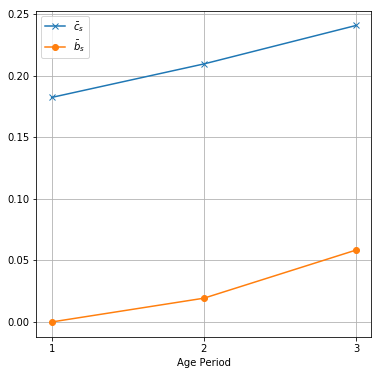

{'b_ss': array([0.01931253, 0.0584111 ]),
 'c_ss': (0.1824121275583131, 0.2096146803090817, 0.24087386507167502),
 'w_ss': 0.20172465739033288,
 'r_ss': 2.433062339132529,
 'K_ss': 0.07772362575295153,
 'Y_ss': 0.6827603788595883,
 'C_ss': 0.6329006729390698,
 'EulErr_ss': (-4.575042567012133e-10, 8.864304845701554e-10),
 'RCerr_ss': 6.938893903907228e-17,
 'ss_time': 0.00028620000000012524}

In [11]:
params = np.array([beta, sigma, nvec, sum(nvec), A, alpha, delta, 10**(-6)])
get_SS(params, (0.1, 0.1), True)

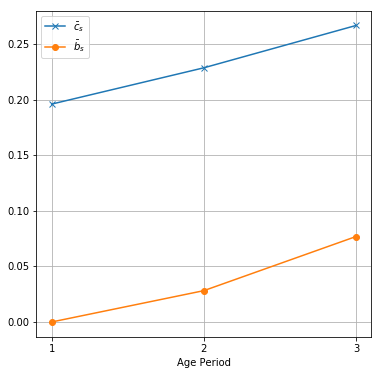

{'b_ss': array([0.02817692, 0.07686545]),
 'c_ss': (0.1959752769965466, 0.22861594134257796, 0.2666930719051805),
 'w_ss': 0.2241521958905792,
 'r_ss': 1.8863765066381661,
 'K_ss': 0.10504237016721853,
 'Y_ss': 0.7586689707065758,
 'C_ss': 0.691284290244305,
 'EulErr_ss': (6.827269771747524e-08, 2.5113720880654e-08),
 'RCerr_ss': 6.938893903907228e-17,
 'ss_time': 0.00021229999999983207}

In [12]:
params = np.array([0.55, sigma, nvec, sum(nvec), A, alpha, delta, 10**(-6)])
get_SS(params, (0.1, 0.1), True)

## Exercise 2.3

In [13]:
import scipy.linalg as la

In [14]:
def Euler(bvec, wage, rent, params):  
    '''
    Inputs:
    bguess: bvec
    wages: w1, w2, w3
    rental rates: r2, r3
    parameters: params
    '''
    
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
    b2, b3 = bvec
    w1, w2, w3 = wage
    r2, r3 = rent
    
    # consumption
    c1 = w1 * nvec[0] - b2
    c2 = w2 * nvec[1] + (1 + r2) * b2 - b3
    c3 = w3 * nvec[2] + (1 + r3) * b3
    
    # Euler errors
    EulErr1 = beta * (1 + r2) * c2 ** (-sigma) - c1 ** (-sigma) 
    EulErr2 = beta * (1 + r3) * c3 ** (-sigma) - c2 ** (-sigma) 
    
    return EulErr1, EulErr2

In [15]:
def Euler2(b3, b2, wage, rent, params):  
    '''
    Inputs:
    bguess: b2, b3
    wages: w2, w3
    rental rates: r2, r3
    parameters: params
    '''
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
    w2, w3 = wage
    r2, r3 = rent
    
    # consumption
    c2 = w2 * nvec[1] + (1 + r2) * b2 - b3
    c3 = w3 * nvec[2] + (1 + r3) * b3
    
    # Euler errors
    EulErr2 = beta * (1 + r3) * c3 ** (-sigma) - c2 ** (-sigma) 
    
    return EulErr2

In [16]:
params = np.array([beta, sigma, nvec, sum(nvec), A, alpha, delta, 10**(-6)])

ss = get_SS(params, (0.1, 0.1), False)
(b2_ss, b3_ss) = ss['b_ss']
r_ss = ss['r_ss']
w_ss = ss['w_ss']

K_ss = b2_ss + b3_ss
b2_0 = 0.8 * b2_ss
b3_0 = 1.1 * b3_ss
K_0 = b2_0 + b3_0

T = 50
xi = 0.6
tol = 10**(-9)
maxiter = 10**3
numiter = 0
diff = 1

Kguess = np.linspace(K_0, K_ss, T)
bguess = np.zeros([2,T])
bguess[:,0] = (b2_0, b3_0)
bguess[:,T-1] = (b2_ss, b3_ss)

In [17]:
while numiter < maxiter and diff > tol:
    wguess = get_w(Kguess, f_params)
    rguess = get_r(Kguess, f_params)
    
    for t in range(0,T-1):
        if t == 0:
            wage = (wguess[t], wguess[t+1])
            rent = (rguess[t], rguess[t+1]) 
            sol = opt.root(lambda b3: Euler2(b3, b2_0, wage, rent, params), 0.1)
            bguess[1,t+1] = sol.x
        else:     
            wage = (wguess[t-1], wguess[t], wguess[t+1])
            rent = (rguess[t], rguess[t+1])
            sol = opt.root(lambda bvec: Euler(bvec,wage,rent,params), (0.1,0.1))
            bvec = sol.x
            bguess[0,t] = bvec[0]
            bguess[1,t+1] = bvec[1]
    
    Knew = sum(bguess)
    diff = la.norm(Knew - Kguess, 2)

    Kupdate = xi * Knew + (1-xi) * Kguess
    Kguess = np.copy(Kupdate)

    numiter += 1

In [18]:
matEulErr = np.zeros([2,T])

for t in range(0, T-1):
    if t == 0:
        wage = (wguess[t], wguess[t+1])
        rent = (rguess[t], rguess[t+1]) 
        matEulErr[1,t+1] = Euler2(bguess[1,1], b2_0, wage, rent, params)
    else:
        wage = (wguess[t-1], wguess[t], wguess[t+1])
        rent = (rguess[t], rguess[t+1])
        bvec = (bguess[0,t], bguess[1,t+1])
        (EulErr1, EulErr2) = Euler(bvec,wage,rent,params)
        matEulErr[0,t] = EulErr1
        matEulErr[1,t+1] = EulErr2

In [19]:
Kpath = Kupdate
wpath = get_w(Kpath, f_params)
rpath = get_r(Kpath, f_params)
Ypath = A * Kpath**alpha * sum(nvec)**(1-alpha)
c1path = wguess[:-1] * nvec[0] - bguess[0,1:]
c2path = wguess[:-1] * nvec[1] + (1+rguess[:-1])*bguess[0,:-1] - bguess[1,1:]
c3path = wguess[:-1] * nvec[2] + (1+rguess[:-1])*bguess[1,:-1]  
Cpath = c1path + c2path + c3path
vecRCerr = Ypath[:-1] - Cpath - Kpath[1:] + (1-delta)*Kpath[:-1]

Maximum of the absolute values of all the Euler errors across the entire time path:

In [20]:
np.abs(matEulErr).max()

1.972452423615323e-09

Maximum of the absolute value of all the aggregate resource constraint errors: 

In [21]:
np.abs(vecRCerr).max()

1.7935383039846542e-10

The equilibrium time paths

In [22]:
def plotpath(path,name,ss):
    plt.plot(path[0:10], label=name)
    plt.hlines(ss, 0, 10, label='steady state')
    plt.xlabel('Time')
    plt.grid()
    plt.title('Time Path of ' + name)
    plt.legend()
    plt.show()

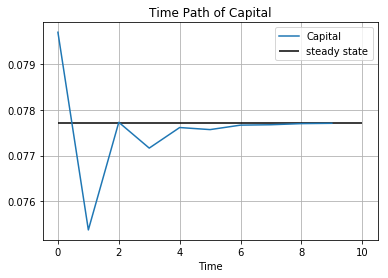

In [23]:
plotpath(Kpath,"Capital", K_ss)

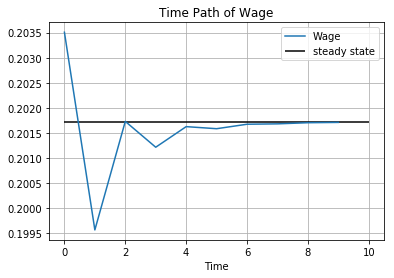

In [24]:
plotpath(wpath,"Wage", w_ss)

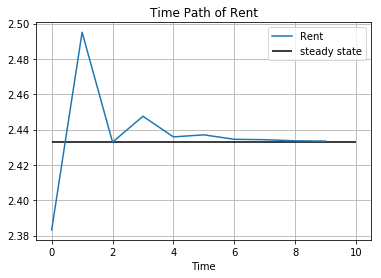

In [25]:
plotpath(rpath,"Rent", r_ss)

In [26]:
np.where(np.abs(Kpath - K_ss)< 0.00001)

(array([ 2, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
        26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
        43, 44, 45, 46, 47, 48, 49], dtype=int64),)